## Predicting the price for an Airbnb Host in Milan

Airbnb has successfully disrupted the traditional hospitality industry as more and more travelers decide to use Airbnb as their primary accommodation provider. Since its inception in 2008, Airbnb has seen an enormous growth, with the number of rentals listed on its website growing exponentially each year.

In Italy, no city is more popular than Milan for tech industry as well as  for tourism industry. That implies that Milan is one of the hottest markets for Airbnb in Europe, with over 18,783 listings as of August 2020. With a size of 181.8 km², this means there are roughly 104 homes being rented out per km² in Berlin on Airbnb!

Considering the possibility that I might have to relocate for a new data science job, but want to keep my current flate (which is quite cheap!), I might wonder if it could be worth it to offer my jewel on Airbnb. Could this perhaps be a profitable option? However, it is difficult for potential hosts to know what the true value of their home is, and how in-demand their home might be. And since location and furniture are obviously fixed for the most part, is there anything else a host can influence - such as description, communication patterns, and/or additional services to boost their earnings?

The following question will drive this project:<br>
> **Can we determine a fairly spot-on daily price for a new accommodation that fits into its specific market environment and competitors in Milan?** <br>

The question focuses on the accommodation features and decisions a new host can make with regards to initial presentation, i.e. posting a picture of him- or herself on the website, determining a minimum length of stay, offering instant bookings etc. A machine learning algorithm will be applied to try to get an answer. 

### The dataset

In the first notebook, I will perform an analysis of the detailed Milan listings data, sourced from the Inside Airbnb website, in order to understand the rental landscape and try to recommend a price for a newbie entering the market. The dataset is named `listings.csv.gz` and was scraped on September 02nd 2020.

### 1. Obtaining and Viewing the Data 


In [80]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import re
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [81]:
pd.options.display.max_columns = None 

df_initial = pd.read_csv('C:/Users/Ankit Patel/Documents/GitHub/Milan Airbnb Prediction/dataset/listings.csv')

# checking shape
print("The dataset has {} rows and {} columns.".format(*df_initial.shape))

# ... and duplicates
print("It contains {} duplicates.".format(df_initial.duplicated().sum()))

The dataset has 18783 rows and 74 columns.
It contains 0 duplicates.


In [35]:
df_initial.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6400,https://www.airbnb.com/rooms/6400,20200831170621,2020-09-01,The Studio Milan,"Enjoy your stay at The Studio, a light-filled ...",The neighborhood is quiet and very well connec...,https://a0.muscache.com/pictures/474737/5955ba...,13822,https://www.airbnb.com/users/show/13822,Francesca,2009-04-17,"Milan, Lombardia, Italy","I'm am Francesca Sottilaro, i live in Milan an...",NaN,NaN,50%,f,https://a0.muscache.com/im/users/13822/profile...,https://a0.muscache.com/im/users/13822/profile...,Zona 5,1.0,1.0,"['email', 'phone', 'reviews']",t,f,"Milan, Lombardy, Italy",TIBALDI,NaN,45.44195,9.17797,Private room in apartment,Private room,1,NaN,3.5 baths,3.0,1.0,"[""Elevator"", ""Host greets you"", ""Breakfast"", ""...",$100.00,4,5,4,4,5,5,4.0,5.0,NaN,t,23,53,83,358,2020-09-01,12,0,0,2010-04-19,2019-04-13,98.0,10.0,10.0,10.0,10.0,9.0,9.0,NaN,f,1,0,1,0,0.10
1,23986,https://www.airbnb.com/rooms/23986,20200831170621,2020-09-01,""" Characteristic Milanese flat""",I look forward to welcoming you in my flat; it...,NaN,https://a0.muscache.com/pictures/623d63f8-56cf...,95941,https://www.airbnb.com/users/show/95941,Jeremy,2010-03-19,"Milan, Lombardy, Italy","Hallo , I'm Jeremy Hayne I live in Milan and I...",within a day,100%,80%,f,https://a0.muscache.com/im/users/95941/profile...,https://a0.muscache.com/im/users/95941/profile...,Navigli,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,NaN,NAVIGLI,NaN,45.44991,9.17597,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,1.0,"[""Paid parking off premises"", ""Bed linens"", ""L...",$150.00,1,730,1,1,730,730,1.0,730.0,NaN,t,24,54,84,359,2020-09-01,14,1,0,2012-04-24,2019-09-02,92.0,9.0,9.0,9.0,9.0,9.0,9.0,NaN,f,1,1,0,0,0.14
2,32119,https://www.airbnb.com/rooms/32119,20200831170621,2020-09-02,Nico & Cynthia's Easy Yellow Suite,<b>The space</b><br />Do you visit Milan for s...,NaN,https://a0.muscache.com/pictures/31c7781c-638a...,138683,https://www.airbnb.com/users/show/138683,Nico&Cinzia,2010-06-05,"Milan, Lombardia, Italy","Hi, we are Nico and Cinzia.. do you like a eas...",within an hour,100%,50%,f,https://a0.muscache.com/im/users/138683/profil...,https://a0.muscache.com/im/users/138683/profil...,Zona 2,4.0,4.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,NaN,VIALE MONZA,NaN,45.51988,9.22310,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,4.0,"[""Elevator"", ""Air conditioning"", ""Kitchen"", ""E...",$107.00,3,730,2,4,730,730,2.6,730.0,NaN,t,29,59,89,364,2020-09-02,15,0,0,2010-06-20,2018-07-01,97.0,10.0,10.0,10.0,10.0,9.0,10.0,NaN,f,4,4,0,0,0.12
3,32649,https://www.airbnb.com/rooms/32649,20200831170621,2020-09-02,Nico&Cinzia's Red Easy Suite!,Larger group can book Red and Pink (r

In [82]:
# check the columns we currently have
df_initial.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

### 2. Preprocessing the Data
#### 2.1. Deciding which columns to work with
Let's imagine we are in the shoes of someone who'd like to offer their home. Fixed features of our property include its rooms, size, and location. We also can decide on how we want to be listed: with a picture or not, how many minimum nights we want a guest to stay, whether we are instantly bookable, how we handle cancellations, etc. But we can neither be a "super host", nor do we have any reviews yet to show - although they can be very important for setting a price. So, let's focus only on features we can influence:

In [83]:
# define the columns we want to keep
#columns_to_keep = ['id', 'description', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
 #                  'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
  #                 'bedrooms', 'beds', 'amenities', 'price',
   #                 'minimum_nights','review_scores_rating',  
    #               'instant_bookable']

#df_raw = df_initial[columns_to_keep].set_index('id')
#print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*df_raw.shape))

In [84]:
# define the columns we want to keep
columns_to_keep = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month']

df_raw = df_initial[columns_to_keep].set_index('id')
print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*df_raw.shape))



The dataset has 18783 rows and 73 columns - after dropping irrelevant columns.


By the way, how many different **room types** do we have?

In [85]:
df_raw.room_type.value_counts(normalize=True)

Entire home/apt    0.746579
Private room       0.231592
Shared room        0.016132
Hotel room         0.005697
Name: room_type, dtype: float64

By the way, how many different **property type** do we have?

In [86]:
df_raw.property_type.value_counts(normalize=True)

Entire apartment                      0.624501
Private room in apartment             0.165256
Entire loft                           0.047756
Entire condominium                    0.045041
Private room in condominium           0.030879
Entire house                          0.014641
Shared room in apartment              0.010914
Private room in house                 0.010488
Entire serviced apartment             0.008572
Private room in loft                  0.006761
Private room in bed and breakfast     0.006069
Shared room in condominium            0.002822
Room in boutique hotel                0.002556
Private room in villa                 0.002289
Room in hotel                         0.002130
Room in serviced apartment            0.001757
Private room in serviced apartment    0.001650
Tiny house                            0.001597
Room in bed and breakfast             0.001544
Private room in guest suite           0.001278
Room in aparthotel                    0.001171
Entire villa 

#### 2.2. Cleaning Columns

In [87]:
df_raw['price'].head()

id
6400     $100.00
23986    $150.00
32119    $107.00
32649     $72.00
37256     $55.00
Name: price, dtype: object

Let's first check if there are any null values in the `price` column:

In [88]:
# checking Nan's in "price" column
df_raw.price.isna().sum()

0

No, so we don't need to drop any rows.

Let's remove the dollar signs in all four columns and convert the string values into numerical ones:

In [89]:
# clean up the columns (by method chaining)
df_raw.price = df_raw.price.str.replace('$', '').str.replace(',', '').astype(float)

We shouldn't miss investigating the `price` - it might need some cleaning to be of use to us:

In [90]:
df_raw['price'].describe()

count    18783.000000
mean       112.952181
std        300.991564
min          8.000000
25%         50.000000
50%         73.000000
75%        110.000000
max      11164.000000
Name: price, dtype: float64

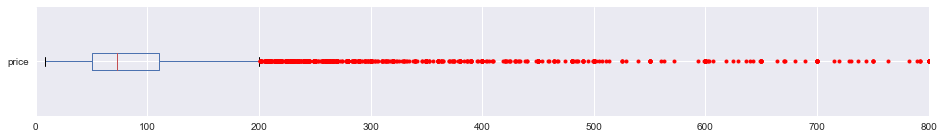

In [91]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_raw['price'].plot(kind='box', xlim=(0, 800), vert=False, flierprops=red_square, figsize=(16,2));

A bit messy, as expected! 

75% of the apartments charge up to 112€ - but the maximum value is 11164€. Let's decide on a limit of 300€, after which the outliers seem to "fringe", and drop all records that charge more than that. Oddly enough, we have prices set to zero. So let's drop those records, too:

In [92]:
df_raw.drop(df_raw[ (df_raw.price > 300) | (df_raw.price == 0) ].index, axis=0, inplace=True)

In [93]:
df_raw['price'].describe()

count    18099.000000
mean        87.721450
std         55.863202
min          8.000000
25%         50.000000
50%         70.000000
75%        101.000000
max        300.000000
Name: price, dtype: float64

In [94]:
print("The dataset has {} rows and {} columns - after being price-wise preprocessed.".format(*df_raw.shape))

The dataset has 18099 rows and 73 columns - after being price-wise preprocessed.


#### 2.3. Dealing with Missing Values

In [95]:
pd.options.display.max_rows = None
df_raw.isna().sum()

listing_url                                         0
scrape_id                                           0
last_scraped                                        0
name                                               11
description                                       390
neighborhood_overview                            7012
picture_url                                         0
host_id                                             0
host_url                                            0
host_name                                           1
host_since                                          1
host_location                                      40
host_about                                       7471
host_response_time                               8335
host_response_rate                               8335
host_acceptance_rate                             4177
host_is_superhost                                   1
host_thumbnail_url                                  1
host_picture_url            

In [96]:
# drop columns with too many Nan's
df_raw.drop(columns=['neighbourhood_group_cleansed', 'bathrooms'], inplace=True)

In [97]:
# drop rows with NaN's in bathrooms and bedrooms
df_raw.dropna(subset=['host_has_profile_pic', 'review_scores_rating', 'beds','bedrooms' ], inplace=True)

In [98]:
df_raw.host_has_profile_pic.unique()
# replace host_has_profile_pic Nan's with no
df_raw.host_has_profile_pic.fillna(value='f', inplace=True)
df_raw.host_has_profile_pic.unique()

array(['t', 'f'], dtype=object)

In [99]:
pd.options.display.max_rows = None
df_raw.isna().sum()

listing_url                                         0
scrape_id                                           0
last_scraped                                        0
name                                                3
description                                       104
neighborhood_overview                            4173
picture_url                                         0
host_id                                             0
host_url                                            0
host_name                                           0
host_since                                          0
host_location                                      16
host_about                                       4756
host_response_time                               5361
host_response_rate                               5361
host_acceptance_rate                             2079
host_is_superhost                                   0
host_thumbnail_url                                  0
host_picture_url            

In [100]:
print("The dataset has {} rows and {} columns - after having dealt with missing values.".format(*df_raw.shape))

The dataset has 12473 rows and 71 columns - after having dealt with missing values.


#### 2.4. Feature Engineering 1: Distance to Centroid (Duomo di Milano) of Milan



Location is always an important factor in lodging services. To make it more descriptive, I decided to calculate each accommodation's distance to the so-called centroid of Milan instead of just relying on the neighbourhoods or areas. 

For our convenience, let's write a quick function that does this, apply it to each accommodation, and store the values in a new column:

In [101]:
from geopy.distance import great_circle

In [102]:
def distance_to_mid(lat, lon):
    milan_centre = ( 45.4641, 9.1919)
    accommodation = (lat, lon)
    return great_circle(milan_centre, accommodation).km

In [103]:
df_raw['distance'] = df_raw.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [104]:
df_raw.head()

,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,distance
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6400,https://www.airbnb.com/rooms/6400,20200831170621,2020-09-01,The Studio Milan,"Enjoy your stay at The Studio, a light-filled ...",The neighborhood is quiet and very well connec...,https://a0.muscache.com/pictures/474737/5955ba...,13822,https://www.airbnb.com/users/show/13822,Francesca,2009-04-17,"Milan, Lombardia, Italy","I'm am Francesca Sottilaro, i live in Milan an...",NaN,NaN,50%,f,https://a0.muscache.com/im/users/13822/profile...,https://a0.muscache.com/im/users/13822/profile...,Zona 5,1.0,1.0,"['email', 'phone', 'reviews']",t,f,"Milan, Lombardy, Italy",TIBALDI,45.44195,9.17797,Private room in apartment,Private room,1,3.5 baths,3.0,1.0,"[""Elevator"", ""Host greets you"", ""Breakfast"", ""...",100.0,4,5,4,4,5,5,4.0,5.0,NaN,t,23,53,83,358,2020-09-01,12,0,0,2010-04-19,2019-04-13,98.0,10.0,10.0,10.0,10.0,9.0,9.0,NaN,f,1,0,1,0,0.10,2.692002
23986,https://www.airbnb.com/rooms/23986,20200831170621,2020-09-01,""" Characteristic Milanese flat""",I look forward to welcoming you in my flat; it...,NaN,https://a0.muscache.com/pictures/623d63f8-56cf...,95941,https://www.airbnb.com/users/show/95941,Jeremy,2010-03-19,"Milan, Lombardy, Italy","Hallo , I'm Jeremy Hayne I live in Milan and I...",within a day,100%,80%,f,https://a0.muscache.com/im/users/95941/profile...,https://a0.muscache.com/im/users/95941/profile...,Navigli,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,NaN,NAVIGLI,45.44991,9.17597,Entire apartment,Entire home/apt,4,1 bath,1.0,1.0,"[""Paid parking off premises"", ""Bed linens"", ""L...",150.0,1,730,1,1,730,730,1.0,730.0,NaN,t,24,54,84,359,2020-09-01,14,1,0,2012-04-24,2019-09-02,92.0,9.0,9.0,9.0,9.0,9.0,9.0,NaN,f,1,1,0,0,0.14,2.008340
32119,https://www.airbnb.com/rooms/32119,20200831170621,2020-09-02,Nico & Cynthia's Easy Yellow Suite,<b>The space</b><br />Do you visit Milan for s...,NaN,https://a0.muscache.com/pictures/31c7781c-638a...,138683,https://www.airbnb.com/users/show/138683,Nico&Cinzia,2010-06-05,"Milan, Lombardia, Italy","Hi, we are Nico and Cinzia.. do you like a eas...",within an hour,100%,50%,f,https://a0.muscache.com/im/users/138683/profil...,https://a0.muscache.com/im/users/138683/profil...,Zona 2,4.0,4.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,NaN,VIALE MONZA,45.51988,9.22310,Entire apartment,Entire home/apt,4,1 bath,1.0,4.0,"[""Elevator"", ""Air conditioning"", ""Kitchen"", ""E...",107.0,3,730,2,4,730,730,2.6,730.0,NaN,t,29,59,89,364,2020-09-02,15,0,0,2010-06-20,2018-07-01,97.0,10.0,10.0,10.0,10.0,9.0,10.0,NaN,f,4,4,0,0,0.12,6.662219
32649,https://www.airbnb.com/rooms/32649,20200831170621,2020-09-02,Nico&Cinzia's Red Easy Suite!,Larger

#### 2.6. Feature Engineering 3: Lodging Amenities

I'm interested in what amenities hosts offer their guests, and in order to enrich our prediction, whether we can determine what some of the more special and/or rare amenities might be that make a property more desirable.

In [105]:
from collections import Counter

In [106]:
results = Counter()
df_raw['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(30)

[(' Heating', 12093),
 (' Essentials', 11762),
 (' Wifi', 10993),
 (' Hair dryer]', 10937),
 (' Kitchen', 10839),
 (' Washer', 9942),
 (' Hangers', 9886),
 (' TV', 9743),
 (' Iron', 9343),
 (' Shampoo', 9315),
 (' Hot water', 8521),
 (' Air conditioning', 7804),
 (' Dishes and silverware', 7230),
 (' Laptop-friendly workspace', 6959),
 (' Cooking basics', 6209),
 (' Refrigerator', 5704),
 (' Bed linens', 5651),
 (' Stove', 5563),
 (' Coffee maker', 5393),
 (' Oven', 5088),
 (' Elevator', 4558),
 (' Microwave', 4322),
 (' Dishwasher', 3837),
 (' Extra pillows and blankets', 3657),
 (' First aid kit', 3439),
 (' Free street parking', 3246),
 (' Long term stays allowed', 3084),
 (' Patio or balcony', 3023),
 (' Private entrance', 2835),
 (' Fire extinguisher', 2643)]

In [107]:
# create a new dataframe
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])

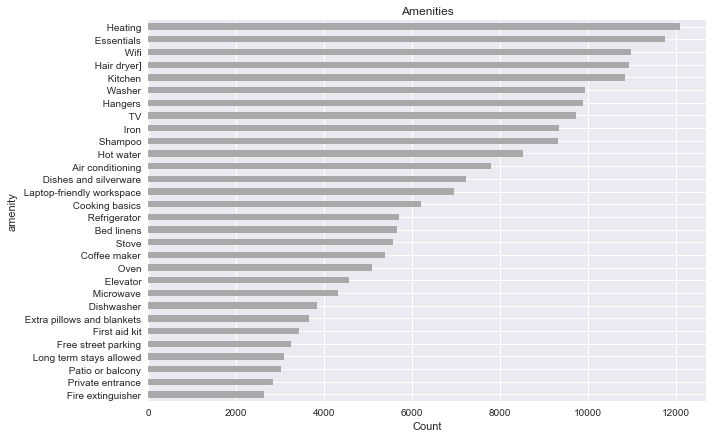

In [108]:
# plot the Top 20
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Amenities')
plt.xlabel('Count');

Let's add columns with amenities that are somewhat unique and not offered by all hosts: 
- a Heating
- a TV
- Wifi
- Kitchen
- Essentials and
- Hair dryer.

After doing this, let's drop the original column:

In [109]:
df_raw['Heating'] = df_raw['amenities'].str.contains('Heating')
df_raw['TV'] = df_raw['amenities'].str.contains('TV')
df_raw['Wifi'] = df_raw['amenities'].str.contains('Wifi')
df_raw['Kitchen'] = df_raw['amenities'].str.contains('Kitchen')
df_raw['Essentials'] = df_raw['amenities'].str.contains('Essentials')
df_raw['Hair dryer'] = df_raw['amenities'].str.contains('Hair dryer')

In [110]:
df_raw.drop(['amenities'], axis=1, inplace=True)

### 3. Exploratory Data Analysis (EDA)

**> Price Differences on a Map**

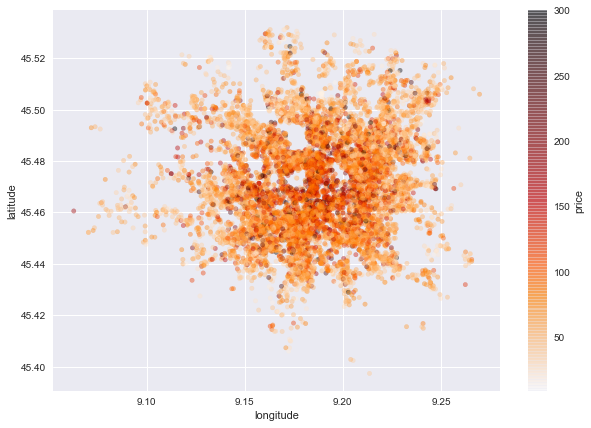

In [111]:
df_raw.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);

**> Price Differences by Neighbourhood**

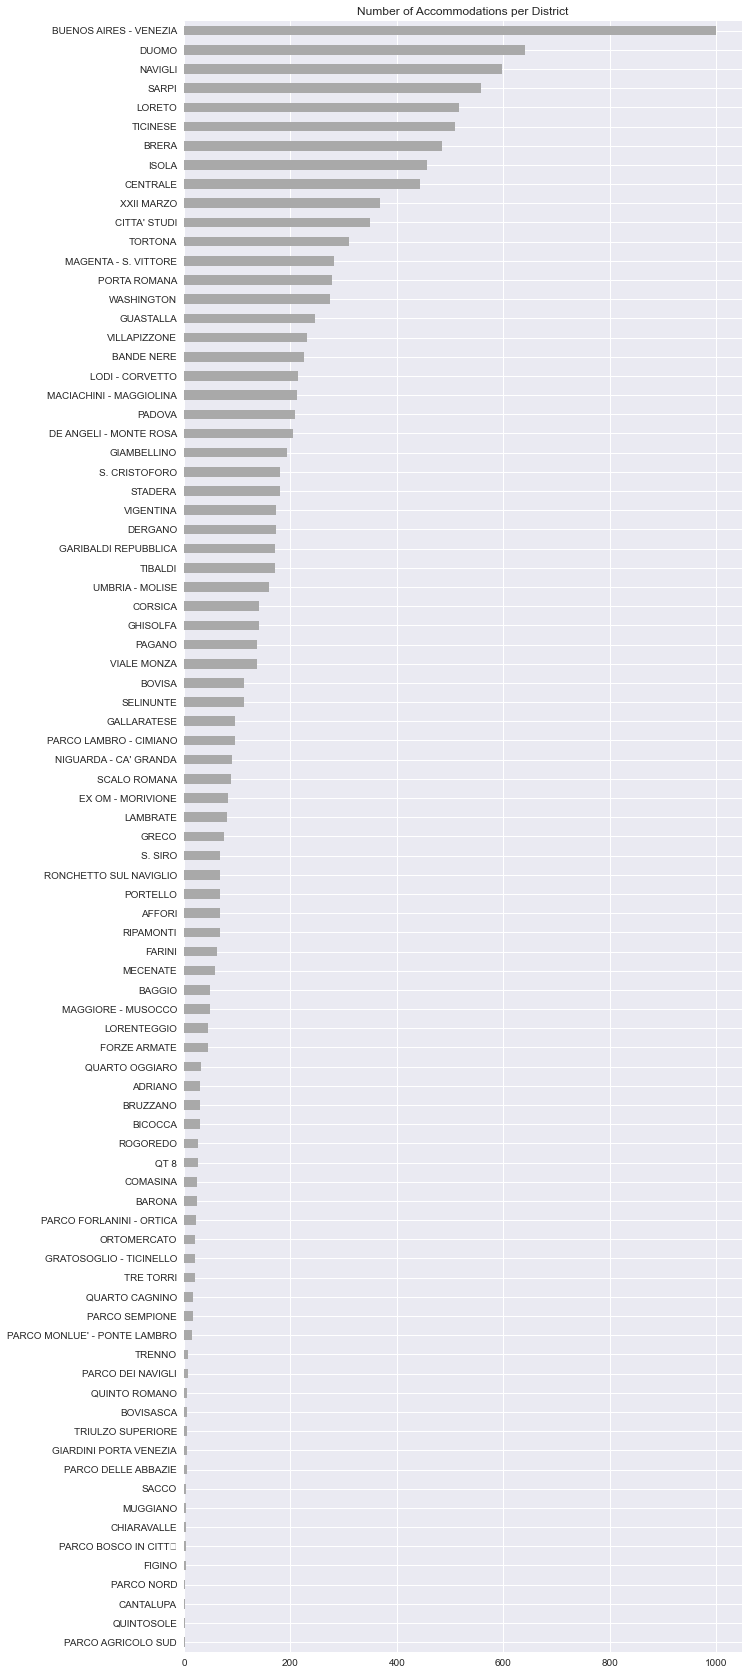

In [112]:
df_raw['neighbourhood_cleansed'].value_counts().sort_values().plot(kind='barh',figsize=(10,30), color='darkgrey')
plt.title('Number of Accommodations per District');

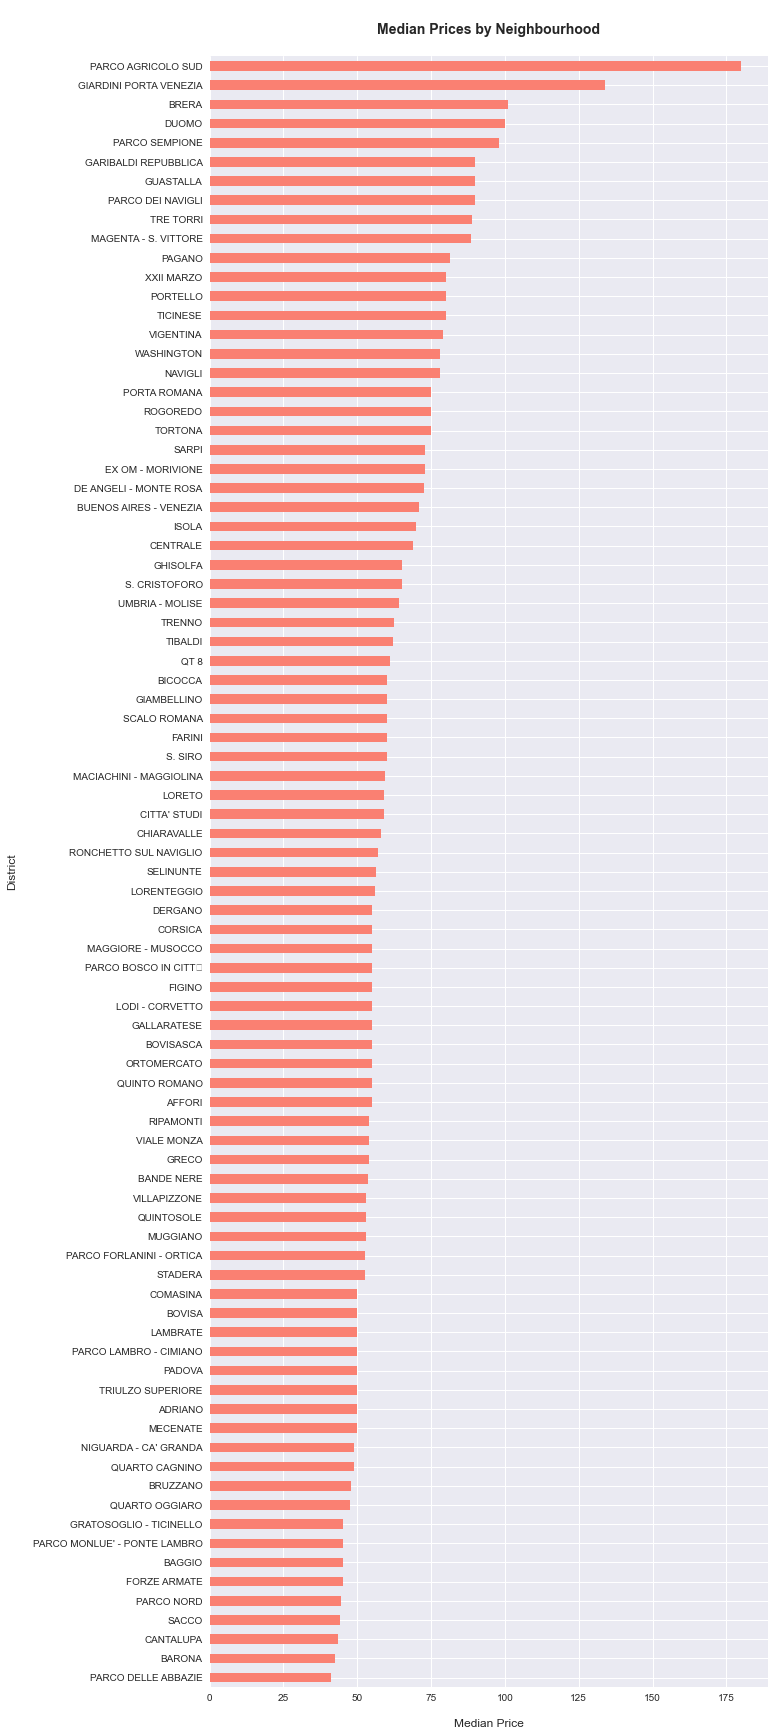

In [113]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_raw_grouped = pd.DataFrame(df_raw.groupby(['neighbourhood_cleansed'])['price'].agg(np.median))
df_raw_grouped.reset_index(inplace=True)

# plot this 
df_raw_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='neighbourhood_cleansed', y='price', 
                figsize=(10,30), legend=False, color='salmon')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold');

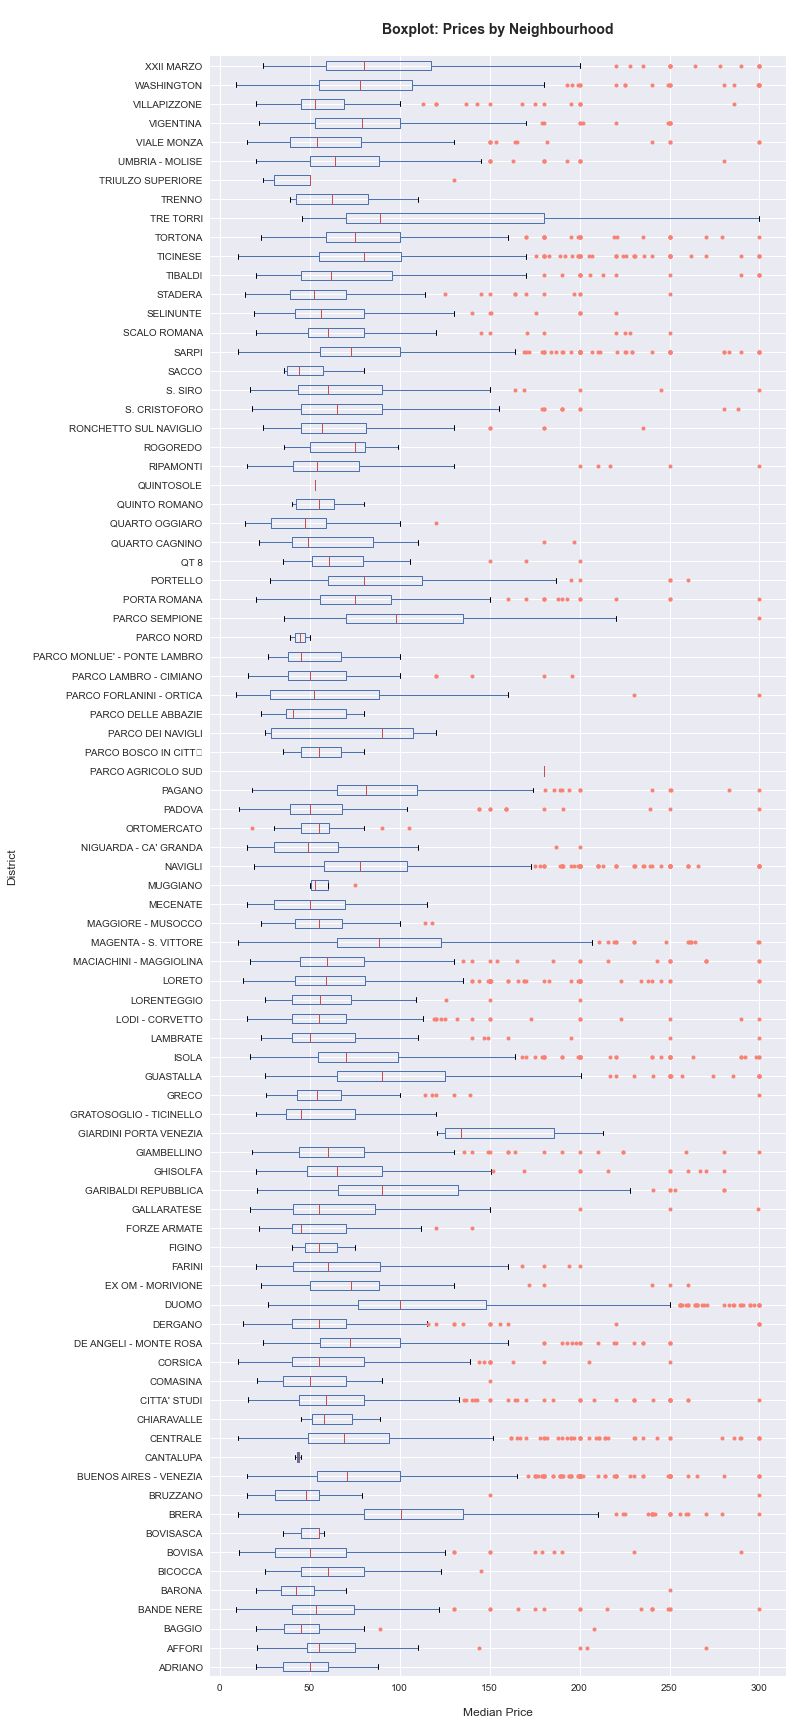

In [114]:
red_square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')

df_raw.boxplot(column='price', by='neighbourhood_cleansed', 
           flierprops=red_square, vert=False, figsize=(10,30))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

# get rid of automatic boxplot title
plt.suptitle('');

**> Price Differences by Accommodation Distance to Center of Berlin**

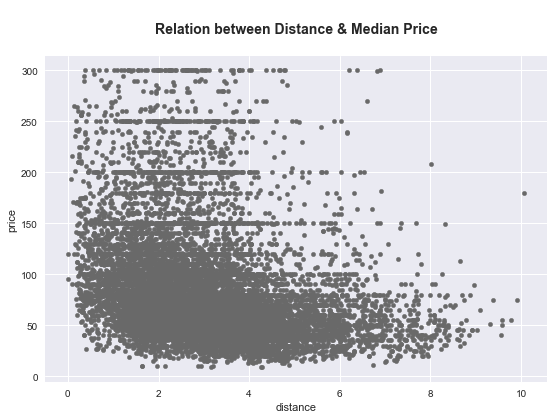

In [115]:
df_raw.plot.scatter(x="distance", y="price", figsize=(9,6), c='dimgrey')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

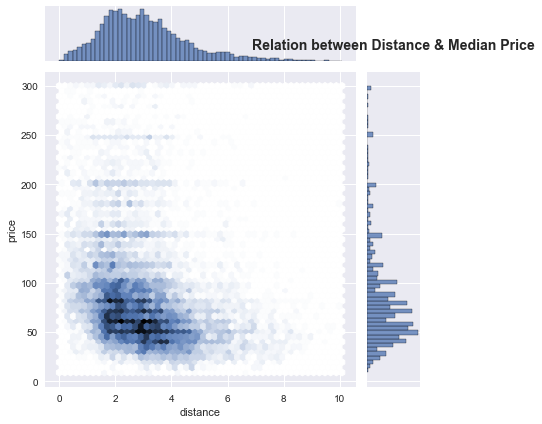

In [116]:
sns.jointplot(x=df_raw["distance"], y=df_raw["price"], kind='hex')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

**> Price Differences by Number of Bedrooms**

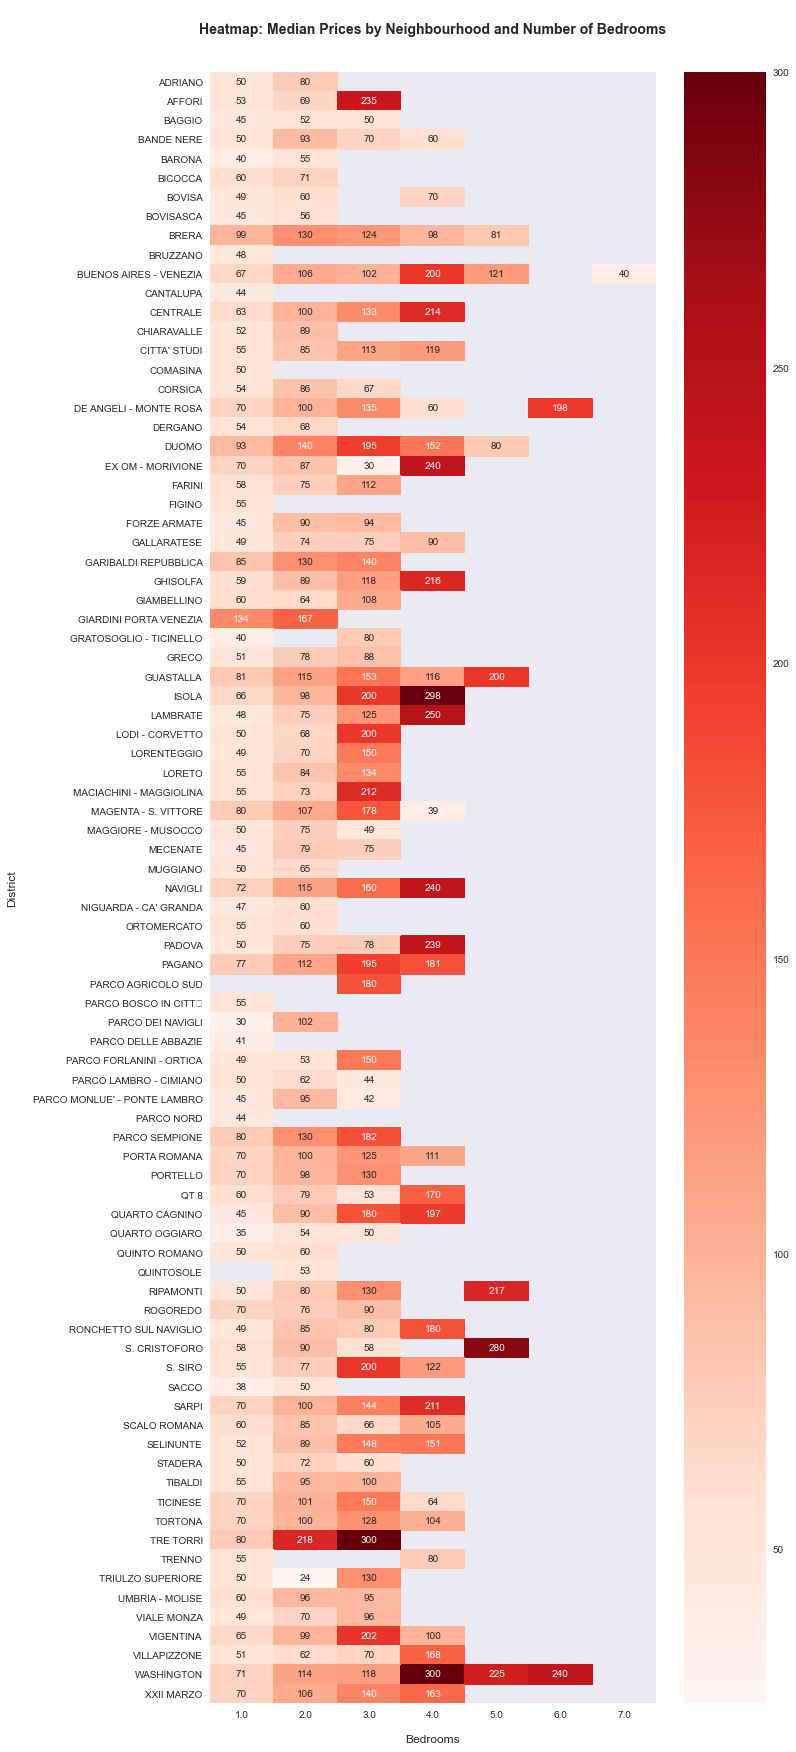

In [117]:
plt.figure(figsize=(10,30))
sns.heatmap(df_raw.groupby(['neighbourhood_cleansed', 'bedrooms']).price.median().unstack(), 
            cmap='Reds', annot=True, fmt=".0f")

plt.xlabel('\nBedrooms', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nHeatmap: Median Prices by Neighbourhood and Number of Bedrooms\n\n', fontsize=14, fontweight='bold');

**> Price Differences by review scores rating**

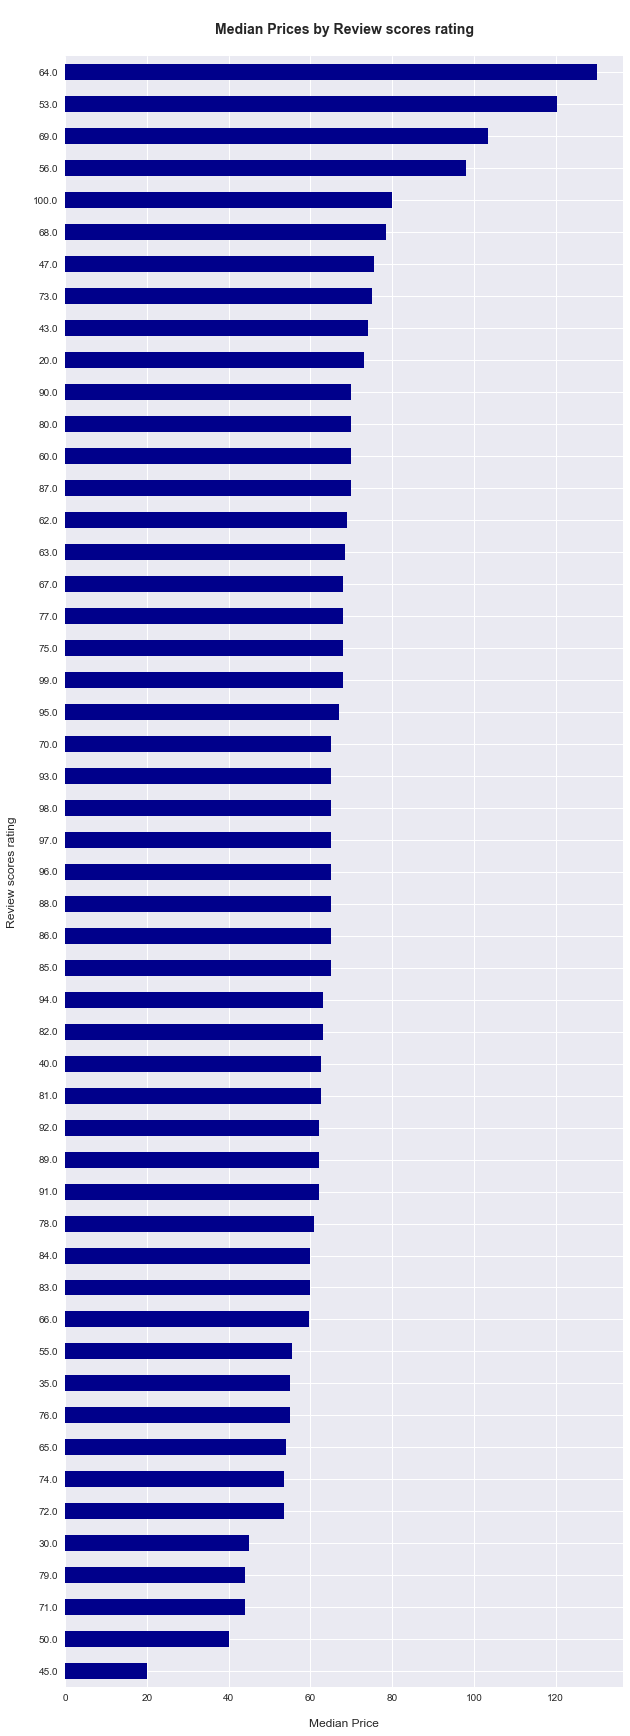

In [118]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_raw_grouped = pd.DataFrame(df_raw.groupby(['review_scores_rating'])['price'].agg(np.median))
df_raw_grouped.reset_index(inplace=True)

# plot this 
df_raw_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='review_scores_rating', y='price', 
                figsize=(10,30), legend=False, color='darkblue')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Review scores rating\n', fontsize=12)
plt.title('\nMedian Prices by Review scores rating\n', fontsize=14, fontweight='bold');

### 4. Modeling the Data

#### 4.1. Preparing Target and Features

In [119]:
df_raw.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60',

In [120]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12473 entries, 6400 to 44941809
Data columns (total 77 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_url                                   12473 non-null  object 
 1   scrape_id                                     12473 non-null  int64  
 2   last_scraped                                  12473 non-null  object 
 3   name                                          12470 non-null  object 
 4   description                                   12369 non-null  object 
 5   neighborhood_overview                         8300 non-null   object 
 6   picture_url                                   12473 non-null  object 
 7   host_id                                       12473 non-null  int64  
 8   host_url                                      12473 non-null  object 
 9   host_name                                     12473 non

Now let's convert all string columns into categorical ones:

In [123]:
df_raw.drop(['latitude', 'longitude', 'neighbourhood_cleansed', 'property_type','host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'accommodates', 'bathrooms_text', 'bedrooms', 
        'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license','calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'], axis=1, inplace=True)

KeyError: "['latitude' 'longitude' 'neighbourhood_cleansed' 'property_type'\n 'host_response_time' 'host_response_rate' 'host_acceptance_rate'\n 'host_is_superhost' 'host_thumbnail_url' 'host_neighbourhood'\n 'host_listings_count' 'host_total_listings_count' 'host_verifications'\n 'host_has_profile_pic' 'host_identity_verified' 'neighbourhood'\n 'accommodates' 'bathrooms_text' 'bedrooms' 'minimum_nights'\n 'maximum_nights' 'minimum_minimum_nights' 'maximum_minimum_nights'\n 'minimum_maximum_nights' 'maximum_maximum_nights'\n 'minimum_nights_avg_ntm' 'maximum_nights_avg_ntm' 'calendar_updated'\n 'has_availability' 'availability_30' 'availability_60' 'availability_90'\n 'availability_365' 'calendar_last_scraped' 'number_of_reviews'\n 'number_of_reviews_ltm' 'number_of_reviews_l30d' 'first_review'\n 'last_review' 'review_scores_rating' 'review_scores_accuracy'\n 'review_scores_cleanliness' 'review_scores_checkin'\n 'review_scores_communication' 'review_scores_location'\n 'review_scores_value' 'license' 'calculated_host_listings_count'\n 'calculated_host_listings_count_entire_homes'\n 'calculated_host_listings_count_private_rooms'\n 'calculated_host_listings_count_shared_rooms' 'reviews_per_month'] not found in axis"

In [124]:
for col in ['host_picture_url', 'room_type', 'beds','instant_bookable']:
    df_raw[col] = df_raw[col].astype('category')

In [125]:
# define our target
target = df_raw[["price"]]

# define our features 
features = df_raw.drop(["price"], axis=1)

***Recoding Categorical Features***

Machine learning algorithms generally need all data - including categorical data - in numeric form. To satisfy these algorithms, categorical features are converted into separate binary features called dummy variables. Therefore, we have to find a way to represent these variables as numbers before handing them off to the model. One typical way of doing this in one-hot encoding, which creates a new column for each unique category in a categorical variable. Each observation receives a 1 in the column for its corresponding category (= "HOT") and a 0 in all other new columns. To conduct one-hot encoding, we use the pandas get_dummies function.

In [126]:
num_feats = features.select_dtypes(include=['float64', 'int64', 'bool']).copy()

# one-hot encoding of categorical features
cat_feats = features.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

In [127]:
features_recoded = pd.concat([num_feats, cat_feats], axis=1)

In [128]:
print(features_recoded.shape)


(12473, 9040)


In [ ]:
features_recoded.head(2)

#### 4.2. Splitting and Scaling the Data

In [ ]:
# import train_test_split function
from sklearn.model_selection import train_test_split
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

# split our data
X_train, X_test, y_train, y_test = train_test_split(features_recoded, target, test_size=0.2)

One of the challenges in building models is mixing features that have different scales. Look at our dataset and compare bathrooms with size or maximum_nights. When we mix units with ranges that have different orders of magnitude, our models may not be able to find the proper coefficients. To account for this problem, we standardize or normalize the features.

In [ ]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

#### 4.3. Training an XGBoost Regressor

In [ ]:
# create a baseline
booster = xgb.XGBRegressor()

Some of the important hyperparameters to tune an XGBoost are:
- `n_estimators` $\;\;\;\;\;$ = Number of trees one wants to build.
- `learning_rate` $\;\;\;\;$= Rate at which our model learns patterns in data. After every round, it shrinks the feature weights to reach the best optimum.
- `max_depth` $\;\;\;\;\;\;\;\;\;\;\;$= Determines how deeply each tree is allowed to grow during any boosting round.
- `colsample_bytree` = Percentage of features used per tree. 
- `gamma` $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$= Specifies the minimum loss reduction required to make a split.

In [ ]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

In [ ]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, 
                           max_depth=6, n_estimators=200, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

In [ ]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

In [ ]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {round(r2, 4)}")

#### 4.4. Cross Validation

In order to build more robust models, it is common to conduct a k-fold cross validation where all the entries in the original training dataset are used for both training and validation. XGBoost supports k-fold cross validation via the cv method. All we have to do is specify the `nfolds` parameter, which is the number of cross validation rounds you want to build. 

Also, it supports many other parameters:
- `num_boost_round` $\;\;\;\;\;\;\;\;$ = Specifies the number of trees to build (analogous to n_estimators).
- `metrics` $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ = Specifies the evaluation metrics to be checked during CV.
- `as_pandas` $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$= Returns the results in a decent pandas DataFrame.
- `early_stopping_rounds` = Finishes model training early if the hold-out metric does not improve for a given number of rounds. 

We will have to first convert the dataset into an optimized data structure called DMatrix so that XGBoost's cross validation method is supported.

In [ ]:
xg_train = xgb.DMatrix(data=X_train, label=y_train)

In [ ]:
params = {'colsample_bytree':0.6, 'gamma':0.2, 'learning_rate':0.05, 'max_depth':6}

cv_results = xgb.cv(dtrain=xg_train, params=params, nfold=3,
                    num_boost_round=200, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True)

In [ ]:
cv_results.head()